In [7]:
#importing libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import yfinance
from ta import add_all_ta_features
import yfinance
from prophet import Prophet
import os
from ta import add_all_ta_features
import pickle

from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

In [8]:

# Data Extraction
#symbols = [ "^NSEI","^NSEBANK" , "^CNXFMCG","NIFTY_FIN_SERVICE.NS","^CNXIT","NIFTY_PVT_BANK.NS","^CNXMETAL"]
# ["INR=X","^DJI","^DJI","^FTSE","BTC-USD","^VIX","RTY=F"]

symbol = "ELGIEQUIP.NS"
#symbols = ["OLECTRA.NS","CONCOR.NS","ELGIEQUIP.NS","IOC.NS","BEL.NS","TATAELXSI.NS","^NSEI","HDFCBANK.NS","TATAMOTORS.NS","SBIN.NS",
#"TCS.NS","TITAN.NS","SUNPHARMA.BO","TECHM.NS", "ASIANPAINT.NS","TATACONSUM.NS"]

#df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
data = yfinance.download (tickers = "{}".format(symbol),start="2007-03-06",
                            interval = "1d", group_by = 'ticker', auto_adjust = True)



data = data[["Open", "High", "Low", "Close","Volume"]]
data["Returns"] = data["Close"].pct_change()
data["Range"] = data["High"] / data["Low"] - 1
data["Avg_Range"] = data["Range"].rolling(window=30).mean()
data.tail()

def exponential_moving_average(data, window):
    if len(data) < window:
        raise ValueError("Data length should be greater than or equal to the window size.")
    
    alpha = 2 / (window + 1)
    ema = [data[0]]

    for i in range(1, len(data)):
        ema_value = alpha * data[i] + (1 - alpha) * ema[-1]
        ema.append(ema_value)
    return ema

[*********************100%***********************]  1 of 1 completed


In [5]:
df = data.copy()
df["TARGET14"] = 0
df["TARGET5"] = 0
df["TARGET21"] = 0

df["TARGET_PREV_14"] = 0
df["TARGET_PREV_5"] = 0
df["TARGET_PREV_21"] = 0
df.loc[df["Close"].shift(14) < df["Close"],"TARGET_PREV_14"] = 1
df.loc[df["Close"].shift(5) < df["Close"],"TARGET_PREV_5"] = 1
df.loc[df["Close"].shift(21) < df["Close"],"TARGET_PREV_21"] = 1 #current price hige


df.loc[df["Close"].shift(-5) > df["Close"],"TARGET5"] = 1
df.loc[df["Close"].shift(-14) > df["Close"],"TARGET14"] = 1
df.loc[df["Close"].shift(-21) > df["Close"],"TARGET21"] = 1


#df.loc[df["Close"].shift(-14) > df["Close"],"TARGET"] = 1

df.dropna(inplace=True)
df.describe()

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,TARGET14,TARGET5,TARGET21,TARGET_PREV_14,TARGET_PREV_5,TARGET_PREV_21
count,4027.000000,4027.000000,4027.000000,4027.000000,4.027000e+03,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000,4027.000000
mean,105.451460,107.691670,103.288663,105.266411,2.057654e+05,0.001293,0.044221,0.044243,0.556245,0.510554,0.571890,0.556990,0.510554,0.573876
std,121.695859,124.471390,119.114299,121.539191,5.659415e+05,0.025942,0.032371,0.015819,0.496888,0.499951,0.494866,0.496803,0.499951,0.494574
min,5.722563,6.070985,5.701448,5.933728,0.000000e+00,-0.133003,0.000000,0.013876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.720426,34.332536,33.203376,33.643108,2.345900e+04,-0.011450,0.024390,0.032772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,61.638033,62.571934,60.237173,61.451263,5.906400e+04,-0.000294,0.035623,0.041381,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,123.503554,125.042909,121.343062,123.160172,1.692440e+05,0.010893,0.053383,0.050343,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,584.503853,618.506776,560.974704,578.993835,1.068248e+07,0.184420,0.375000,0.118655,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
#g = sns.FacetGrid(df, col="Avg_Range", row="TARGET")
#g.map_dataframe(sns.scatterplot, x="Avg_Range", y="TARGET")
#g.set_axis_labels("Total Bill ($)", "Tip ($)")
#plt.show()

In [9]:
#moving av
df['MA5'] = df.Close.rolling(window=5).mean()
df['EMA5'] = exponential_moving_average(df.Close.values,5)

df['MA10'] = df.Close.rolling(window=50).mean()
df['EMA10'] = exponential_moving_average(df.Close.values,10)

df['MA20'] = df.Close.rolling(window=20).mean()
df['EMA20'] = exponential_moving_average(df.Close.values,20)

df['MA50'] = df.Close.rolling(window=50).mean()
df['EMA50'] = exponential_moving_average(df.Close.values,50)

df['MA100'] = df.Close.rolling(window=100).mean()
df['EMA100'] = exponential_moving_average(df.Close.values,100)

#df['MA200'] =  df.Close.rolling(window=200).mean()
df.dropna(inplace=True)


In [10]:
#prophet
pro_df = df.copy()
pro_df["Date"] = pd.to_datetime(pro_df.index)
#renaming variables
pro_df = pro_df.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
pro_df.reset_index()

pro_df.tail(10)


,Open,High,Low,y,Volume,Returns,Range,Avg_Range,TARGET14,TARGET5,...,EMA5,MA10,EMA10,MA20,EMA20,MA50,EMA50,MA100,EMA100,ds
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-01,538.900024,543.900024,536.750000,539.700012,218964,0.007749,0.013321,0.029109,0,0,...,542.637459,542.658959,546.955155,551.662811,547.692118,542.658959,534.282910,503.514742,511.020457,2023-08-01
2023-08-02,541.349976,544.950012,527.000000,532.250000,216279,-0.013804,0.034061,0.029500,0,0,...,539.174972,542.596743,544.281490,551.440259,546.221440,542.596743,534.203188,504.117530,511.440844,2023-08-02
2023-08-03,532.200012,533.950012,505.600006,516.299988,352835,-0.029967,0.056072,0.030674,0,0,...,531.549978,541.580143,539.193944,550.472327,543.371778,541.580143,533.501102,504.646693,511.537065,2023-08-03
2023-08-04,521.900024,521.900024,508.850006,510.700012,169276,-0.010846,0.025646,0.029780,0,0,...,524.599989,540.734487,534.013229,549.266589,540.260181,540.734487,532.606941,505.100496,511.520490,2023-08-04
2023-08-07,515.900024,519.900024,504.000000,518.500000,265614,0.015273,0.031548,0.029393,0,0,...,522.566659,540.310898,531.192642,548.071109,538.187783,540.310898,532.053728,505.629322,511.658698,2023-08-07
2023-08-08,522.000000,524.950012,502.149994,508.450012,290840,-0.019383,0.045405,0.029777,0,0,...,517.861110,539.600930,527.057619,546.415323,535.355614,539.600930,531.128092,505.968792,511.595159,2023-08-08
2023-08-09,512.200012,513.450012,504.299988,509.549988,198882,0.002163,0.018144,0.028523,0,0,...,515.090736,539.192928,523.874413,542.943130,532.897936,539.192928,530.281892,506.349543,511.554661,2023-08-09
2023-08-10,511.950012,512.450012,505.000000,506.299988,138745,-0.006378,0.014752,0.029015,0,0,...,512.160487,538.707020,520.679063,540.117557,530.364798,538.707020,529.341425,506.597026,511.450608,2023-08-10
2023-08-11,508.799988,511.600006,502.500000,504.250000,147008,-0.004049,0.018109,0.028743,0,0,...,509.523658,538.057006,517.691961,536.889169,527.877674,538.057006,528.357447,506.885066,511.308022,2023-08-11


In [12]:
holiday = [
    {
        "name": "Holi",
        "date": "2000-03-20",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2000-09-01",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2000-10-07",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2000-10-26",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2000-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2001-03-10",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2001-08-22",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2001-10-26",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2001-11-14",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2001-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2002-03-29",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2002-09-10",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2002-10-15",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2002-11-04",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2002-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2003-03-18",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2003-08-31",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2003-10-05",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2003-10-25",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2003-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2004-03-07",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2004-09-18",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2004-10-22",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2004-11-12",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2004-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2005-03-26",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2005-09-07",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2005-10-12",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2005-11-01",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2005-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2006-03-15",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2006-08-27",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2006-10-02",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2006-10-21",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2006-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2007-03-04",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2007-09-15",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2007-10-21",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2007-11-09",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2007-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2008-03-22",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2008-09-03",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2008-10-09",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2008-10-28",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2008-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2009-03-11",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2009-08-23",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2009-09-28",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2009-10-17",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2009-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2010-03-01",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2010-09-11",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2010-10-17",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2010-11-05",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2010-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2011-03-20",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2011-09-01",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2011-10-06",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2011-10-26",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2011-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2012-03-08",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2012-09-19",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2012-10-24",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2012-11-13",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2012-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2013-03-27",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2013-09-09",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2013-10-13",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2013-11-03",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2013-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2014-03-17",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2014-08-29",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2014-10-03",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2014-10-23",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2014-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2015-03-06",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2015-09-17",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2015-10-22",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2015-11-11",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2015-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2016-03-24",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2016-09-05",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2016-10-11",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2016-10-30",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2016-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2017-03-13",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2017-08-25",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2017-09-30",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2017-10-19",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2017-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2018-03-02",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2018-09-13",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2018-10-19",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2018-11-07",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2018-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2019-03-21",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2019-09-02",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2019-10-08",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2019-10-27",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2019-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2020-03-10",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2020-08-22",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2020-10-25",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2020-11-14",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2020-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2021-03-29",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2021-09-10",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2021-10-15",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2021-11-04",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2021-12-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Holi",
        "date": "2022-03-18",
        "before": 0,
        "after": 3
    },
    {
        "name": "Ganesh Chaturthi/Vinayaka Chaturthi",
        "date": "2022-08-31",
        "before": 3,
        "after": 2
    },
    {
        "name": "Dussehra",
        "date": "2022-10-05",
        "before": 0,
        "after": 1
    },
    {
        "name": "Diwali/Deepavali",
        "date": "2022-10-24",
        "before": 0,
        "after": 2
    },
    {
        "name": "Christmas Eve",
        "date": "2022-12-24",
        "before": 0,
        "after": 2
    }
]

In [15]:
holid_df = pd.DataFrame(holiday)
holid_df.rename(columns={'name': 'holiday'}, inplace=True)
holid_df.rename(columns={'date': 'ds'}, inplace=True)

holid_df

,holiday,ds,before,after
0,Holi,2000-03-20,0,3
1,Ganesh Chaturthi/Vinayaka Chaturthi,2000-09-01,3,2
2,Dussehra,2000-10-07,0,1
3,Diwali/Deepavali,2000-10-26,0,2
4,Christmas Eve,2000-12-24,0,2
...,...,...,...,...
110,Holi,2022-03-18,0,3
111,Ganesh Chaturthi/Vinayaka Chaturthi,2022-08-31,3,2
112,Dussehra,2022-10-05,0,1
113,Diwali/Deepavali,2022-10-24,0,2


In [16]:
m = Prophet(
            holidays = holid_df,
            #seasonality_mode = 'multiplicative',
           # seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(pro_df)
forecast = m.predict(pro_df)
forecast.head(5)

09:42:41 - cmdstanpy - INFO - Chain [1] start processing
09:42:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Eve,Christmas Eve_lower,Christmas Eve_upper,Diwali/Deepavali,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-30,13.129554,-14.152763,33.545848,13.129554,13.129554,0.0,0.0,0.0,0.0,...,-3.001760,-3.001760,-3.001760,0.515944,0.515944,0.515944,0.0,0.0,0.0,10.643738
1,2008-01-31,13.124394,-12.769636,34.578017,13.124394,13.124394,0.0,0.0,0.0,0.0,...,-2.579209,-2.579209,-2.579209,0.582031,0.582031,0.582031,0.0,0.0,0.0,11.127216
2,2008-02-01,13.119235,-13.222053,34.589704,13.119235,13.119235,0.0,0.0,0.0,0.0,...,-2.601331,-2.601331,-2.601331,0.666882,0.666882,0.666882,0.0,0.0,0.0,11.184786
3,2008-02-04,13.103756,-12.133510,34.117467,13.103756,13.103756,0.0,0.0,0.0,0.0,...,-3.107341,-3.107341,-3.107341,1.019548,1.019548,1.019548,0.0,0.0,0.0,11.015963
4,2008-02-05,13.098596,-13.429806,33.693952,13.098596,13.098596,0.0,0.0,0.0,0.0,...,-3.212607,-3.212607,-3.212607,1.163392,1.163392,1.163392,0.0,0.0,0.0,11.049381


In [6]:
forecast.tail()
with open('../../TrainedModel/fp_tech_indicator/{}.pkl'.format(symbol), 'wb') as f:
     pickle.dump(m, f)

In [9]:
#forecast["yearly"] = 0
#forecast["weekly"] = 0
forecast["ma20above50"] = 0
forecast["ma50above100"] = 0
forecast["ma20above100"] = 0
forecast["ma5"] = 0
forecast["ma10"] = 0
forecast["ma20"] = 0
forecast["ma50"] = 0
forecast["ma100"] = 0
forecast["ema5"] = 0
forecast["ema10"] = 0
forecast["ema20"] = 0
forecast["ema50"] = 0
forecast["ema100"] = 0
#forecast["TARGET"] = 0


forecast["Close"] =  pro_df['y'].values
forecast["TARGET21"] =  pro_df['TARGET21'].values
forecast["TARGET5"] =  pro_df['TARGET5'].values

forecast["TARGET14"] =  pro_df['TARGET14'].values

forecast["TARGET_PREV_14"] =  pro_df['TARGET14'].values
forecast["TARGET_PREV_5"] =  pro_df['TARGET14'].values
forecast["TARGET_PREV_21"] =  pro_df['TARGET14'].values



forecast["MA20"] =  pro_df['MA20'].values
forecast["MA100"] =  pro_df['MA100'].values
forecast["MA50"] =  pro_df['MA50'].values
forecast["MA5"] =  pro_df['MA5'].values
forecast["MA10"] =  pro_df['MA10'].values

forecast["EMA20"] =  pro_df['EMA20'].values
forecast["EMA100"] =  pro_df['EMA100'].values
forecast["EMA50"] =  pro_df['EMA50'].values
forecast["EMA5"] =  pro_df['EMA5'].values
forecast["EMA10"] =  pro_df['EMA10'].values
#forecast.loc[forecast["Close"].shift(-1) > forecast["Close"],"TARGET"] = 1

forecast.loc[forecast["MA5"] < forecast["Close"],"ma5"] = 1
forecast.loc[forecast["EMA5"] < forecast["Close"],"ema5"] = 1

forecast.loc[forecast["MA10"] < forecast["Close"],"ema10"] = 1
forecast.loc[forecast["EMA10"] < forecast["Close"],"ema10"] = 1


forecast.loc[forecast["MA20"] < forecast["Close"],"ema20"] = 1
forecast.loc[forecast["EMA20"] < forecast["Close"],"ema20"] = 1

forecast.loc[forecast["MA50"] < forecast["Close"],"ema50"] = 1
forecast.loc[forecast["EMA50"] < forecast["Close"],"ema50"] = 1

forecast.loc[forecast["MA100"] < forecast["Close"],"ema100"] = 1
forecast.loc[forecast["EMA100"] < forecast["Close"],"ema100"] = 1




#forecast.loc[forecast["yearly"].shift(-1) > forecast["yearly"],"yearly"] = 1

#forecast.loc[forecast["weekly"].shift(-1) > forecast["weekly"],"weekly"] = 1

forecast.loc[forecast["MA20"] > forecast["MA50"],'ma20above50'] = 1
forecast.loc[forecast["MA50"] > forecast["MA100"],'ma50above100'] = 1
forecast.loc[forecast["MA20"] > forecast["MA100"],'ma20above100'] = 1

forecast.dropna(inplace=True)
#new_forecastdf.tail(10)
#forecast['Close'] = pro_df['y'].values
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'ma20above50', 'ma50above100',
       'ma20above100', 'ma5', 'ma10', 'ma20', 'ma50', 'ma100', 'ema5', 'ema10',
       'ema20', 'ema50', 'ema100', 'Close', 'TARGET21', 'TARGET5', 'TARGET14',
       'TARGET_PREV_14', 'TARGET_PREV_5', 'TARGET_PREV_21', 'MA20', 'MA100',
       'MA50', 'MA5', 'MA10', 'EMA20', 'EMA100', 'EMA50', 'EMA5', 'EMA10'],
      dtype='object')

EMA20
11.002125     1
131.488325    1
131.155450    1
130.631406    1
130.060694    1
             ..
41.526444     1
41.660218     1
41.896090     1
41.972992     1
527.877674    1
Name: count, Length: 3928, dtype: int64

<Axes: >

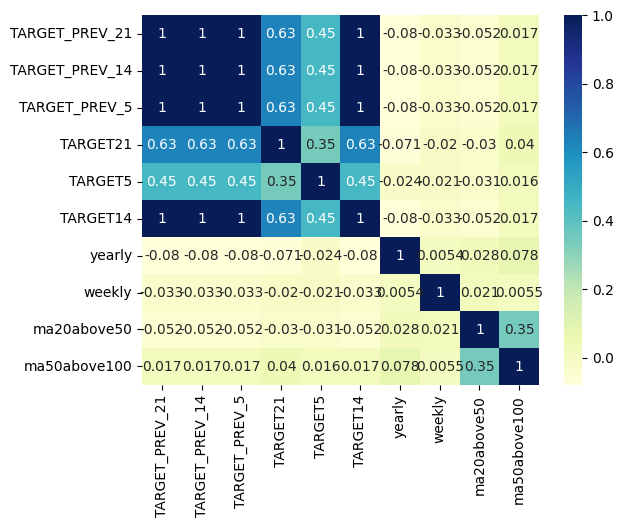

In [10]:
new_df = forecast.copy()
#new_df

new_df1 = new_df[["TARGET_PREV_21","TARGET_PREV_14","TARGET_PREV_5","TARGET21","TARGET5","TARGET14","yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"]]
new_df1
#new_df1.to_csv('data.csv')
sns.heatmap(data=new_df[["TARGET_PREV_21","TARGET_PREV_14","TARGET_PREV_5","TARGET21","TARGET5","TARGET14","yearly","weekly","ma20above50","ma50above100"]].corr(),annot=True,cmap='YlGnBu')


In [14]:
forecast.describe().T

,count,mean,min,25%,50%,75%,max,std
ds,3928,2015-08-29 17:53:02.077393152,2007-09-07 00:00:00,2011-08-29 18:00:00,2015-08-27 12:00:00,2019-08-27 06:00:00,2023-08-11 00:00:00,NaN
trend,3928.0,109.189661,9.979366,36.965543,65.317434,126.35294,541.873892,120.554856
yhat_lower,3928.0,84.058464,-24.641267,10.763444,40.966536,100.803072,516.869837,120.552612
yhat_upper,3928.0,131.221197,22.009583,57.825732,88.132726,147.80875,562.952237,120.554259
trend_lower,3928.0,109.189661,9.979366,36.965543,65.317434,126.35294,541.873892,120.554856
trend_upper,3928.0,109.189661,9.979366,36.965543,65.317434,126.35294,541.873892,120.554856
additive_terms,3928.0,-1.539775,-10.059741,-3.327298,-1.223886,0.864967,16.755601,3.473041
additive_terms_lower,3928.0,-1.539775,-10.059741,-3.327298,-1.223886,0.864967,16.755601,3.473041
additive_terms_upper,3928.0,-1.539775,-10.059741,-3.327298,-1.223886,0.864967,16.755601,3.473041
weekly,3928.0,-1.592166,-9.106628,-1.756397,-1.686473,-1.338678,17.073518,0.406286


In [21]:
forecast.groupby(['TARGET_PREV_14'])['TARGET_PREV_5'].sum().sort_values(ascending = False).head(100)

TARGET_PREV_14
1    2179
0       0
Name: TARGET_PREV_5, dtype: int64

In [9]:
#visulazation
import seaborn as sns


In [10]:
new_df1.describe()

,TARGET,yearly,weekly,ma20above50,ma50above100,ma20above100,ma5,ma20,ma50,ma100,ema5,ema10,ema20,ema50,ema100
count,4036.000000,4036.000000,4036.000000,4036.000000,4036.000000,4036.000000,4036.000000,4036.0,4036.0,4036.0,4036.000000,4036.000000,4036.000000,4036.000000,4036.000000
mean,0.523043,0.082126,5.671533,0.543112,0.579286,0.588949,0.533449,0.0,0.0,0.0,0.541378,0.662042,0.568632,0.572597,0.626115
std,0.499531,11.917412,0.256955,0.498200,0.493735,0.492085,0.498942,0.0,0.0,0.0,0.498347,0.473073,0.495329,0.494763,0.483894
min,0.000000,-28.685872,5.310383,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-7.590671,5.413795,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.781351,5.881298,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,9.168805,5.881900,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,22.443002,5.882237,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='ma50'>

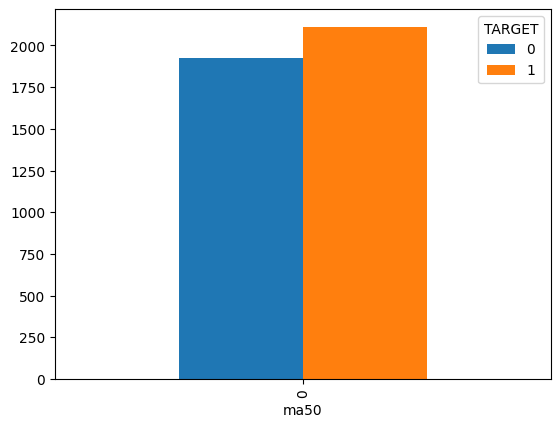

In [11]:
#sns.displot(x=new_df1["TARGET"],bins=3,kde=True)
#sns.boxplot(x=new_df1["yearly"])
#plt.pie(new_df1["ma20above100"].value_counts(),labels=new_df1["ma20above100"].value_counts().index)
#"yearly","weekly","ma20above50","ma50above100","ma20above100","ma5","ma20","ma50","ma100","ema5","ema10","ema20","ema50","ema100"
#sns.scatterplot(x=new_df1["weekly"],y=new_df1["TARGET"])
#sns.lmplot(data=new_df1,x="yearly",y="TARGET")
#sns.boxplot(x=new_df1["yearly"],y=new_df1["TARGET"])
ct = pd.crosstab(new_df1["ma50"],new_df1["TARGET"])
ct
ct.plot(kind="bar",stacked=False)